# Градиентный спуск

В этом домашнем задании вы напишете градиентный спуск для линейной регрессии, а так же посмотрите, как он ведёт себя с разными параметрами и разными функциями потерь.

Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек.  

In [2]:
import abc

import matplotlib.pyplot as plt
import numpy as np

## Часть 1. Градиентный спуск (5 баллов)

Для обучения линейной регрессии необходим функционал ошибки, определим интерфейс для последующих реализаций.

In [3]:
class BaseLoss(abc.ABC):
    """Base class for losses"""

    @abc.abstractmethod
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """Calculate loss value based on inputs and weights

        Args:
            X: array with dataset objects, (n_samples, n_features)
            y: array with ground truth values, (n_samples,)
            w: linear regression weights, (n_features,)

        Returns:
            number, loss value
        """
        raise NotImplementedError

    @abc.abstractmethod
    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """Calculate gradient vector based on inputs and weights

        Args:
            X: array with dataset objects, (n_samples, n_features)
            y: array with ground truth values, (n_samples,)
            w: linear regression weights, (n_features,)

        Returns:
            gradients for weights, (n_features,)
        """
        raise NotImplementedError

Вспомним самый простой функционал ошибки, который мы применяем в задаче регрессии — Mean Squared Error:

$$
Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell (\langle x_i, w \rangle - y_i)^2
$$

где $x_i$ — это $i$-ый объект датасета, $y_i$ — правильный ответ для $i$-го объекта, а $w$ — веса нашей линейной модели.

Как мы помним, для линейной модели, его можно записать в матричном виде вот так:

$$
Q(w, X, y) = \frac{1}{\ell} || Xw - y ||^2
$$

где $X$ — это матрица объекты-признаки, а $y$ — вектор правильных ответов

Для того чтобы воспользоваться методом градиентного спуска, нам нужно посчитать градиент нашего функционала. Для MSE он будет выглядеть так:

$$
\nabla_w Q(w, X, y) = \frac{2}{\ell} X^T(Xw-y)
$$

In [4]:
class MSELoss(BaseLoss):
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        error = X @ w - y
        return np.mean(error**2)

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        return 2 / y.size * X.T @ (X @ w - y)

In [5]:
# Проведем небольшую проверку реализации


# Создадим объект лосса
loss = MSELoss()

# Создадим какой-то датасет
X = np.arange(200).reshape(20, 10)
y = np.arange(20)

# Создадим какой-то вектор весов
w = np.arange(10)

# Выведем значение лосса и градиента на этом датасете с этим вектором весов
print(loss.calc_loss(X, y, w))
print(loss.calc_grad(X, y, w))

# Проверка, что методы реализованы правильно
assert loss.calc_loss(X, y, w) == 27410283.5, "Метод calc_loss реализован неверно"
assert np.allclose(
    loss.calc_grad(X, y, w),
    np.array(
        [
            1163180.0,
            1172281.0,
            1181382.0,
            1190483.0,
            1199584.0,
            1208685.0,
            1217786.0,
            1226887.0,
            1235988.0,
            1245089.0,
        ]
    ),
), "Метод calc_grad реализован неверно"
print("Всё верно!")

27410283.5
[1163180. 1172281. 1181382. 1190483. 1199584. 1208685. 1217786. 1226887.
 1235988. 1245089.]
Всё верно!


Теперь когда у нас есть всё для вычисления градиента, давайте напишем наш градиентный спуск. Напомним, что формула для одной итерации градиентного спуска выглядит следующим образом:

$$
w^t = w^{t-1} - \eta \nabla_{w} Q(w^{t-1}, X, y)
$$

Где $w^t$ — значение вектора весов на $t$-ой итерации, а $\eta$ — параметр learning rate, отвечающий за размер шага.

In [6]:
def gradient_descent(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    n_iterations: int = 100000,
) -> np.ndarray:
    """Weights optimization with gradient descent

    Args:
        w_init: initial weights, (n_features,)
        X: array with dataset objects, (n_samples, n_features)
        y: array with ground truth values, (n_samples,)
        loss: BaseLoss instance to calculate loss and gradients
        lr: learning rate, float
        n_iterations: number of iterations, int

    Returns:
        History of weights on each step, (n_iterations, n_features)
    """
    w_history = np.zeros((n_iterations, w_init.size))
    curr_w = w_init.copy()

    for i in range(n_iterations):
        grad = loss.calc_grad(X, y, curr_w)
        curr_w -= lr * grad
        w_history[i] = curr_w
    return w_history

Теперь создадим синтетический датасет и функцию, которая будет рисовать траекторию градиентного спуска по истории:

In [7]:
# Создаём датасет из двух переменных и реального вектора зависимости w_true


np.random.seed(1337)

n_features = 2
n_objects = 300
batch_size = 10
num_steps = 43

w_true = np.random.normal(size=(n_features,))

X = np.random.uniform(-5, 5, (n_objects, n_features))
X *= (np.arange(n_features) * 2 + 1)[np.newaxis, :]
y = X.dot(w_true) + np.random.normal(0, 1, (n_objects))
w_init = np.random.uniform(-2, 2, (n_features))

print(X.shape)
print(y.shape)

(300, 2)
(300,)


In [8]:
loss = MSELoss()
w_list = gradient_descent(w_init, X, y, loss, 0.01, 100)
print(loss.calc_loss(X, y, w_list[0]))
print(loss.calc_loss(X, y, w_list[-1]))

155.26258214351958
0.8670644395649493


In [9]:
def plot_gd(w_list: np.ndarray, X: np.ndarray, y: np.ndarray, loss: BaseLoss):
    """Plot gradient descent trajectory

    Args:
        w_list: weights history, (n_iterations, n_features)
        X: array with dataset objects, (n_samples, n_features)
        y: array with ground truth values, (n_samples,)
        loss: BaseLoss instance to calculate loss and gradients
    """
    w_list = np.array(w_list)
    meshgrid_space = np.linspace(-2, 2, 100)
    A, B = np.meshgrid(meshgrid_space, meshgrid_space)

    levels = np.empty_like(A)
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            w_tmp = np.array([A[i, j], B[i, j]])
            levels[i, j] = loss.calc_loss(X, y, w_tmp)

    plt.figure(figsize=(15, 6))
    plt.title("GD trajectory")
    plt.xlabel(r"$w_1$")
    plt.ylabel(r"$w_2$")
    plt.xlim(w_list[:, 0].min() - 0.1, w_list[:, 0].max() + 0.1)
    plt.ylim(w_list[:, 1].min() - 0.1, w_list[:, 1].max() + 0.1)
    plt.gca().set_aspect("equal")

    # visualize the level set
    CS = plt.contour(A, B, levels, levels=np.logspace(0, 1, num=20), cmap=plt.cm.rainbow_r)
    CB = plt.colorbar(CS, shrink=0.8, extend="both")

    # visualize trajectory
    plt.scatter(w_list[:, 0], w_list[:, 1])
    plt.plot(w_list[:, 0], w_list[:, 1])

    plt.show()

При помощи функций `gradient_descent` и  `plot_gd` нарисуйте траекторию градиентного спуска для разных значений длины шага (параметра `lr`). Используйте не менее четырёх разных значений для `lr`. Хорошие значения для `lr` могут лежать в промежутке от 0.0001 до 0.1

Сделайте и опишите свои выводы о том, как параметр `lr` влияет на поведение градиентного спуска

Learning Rate = 0.0001


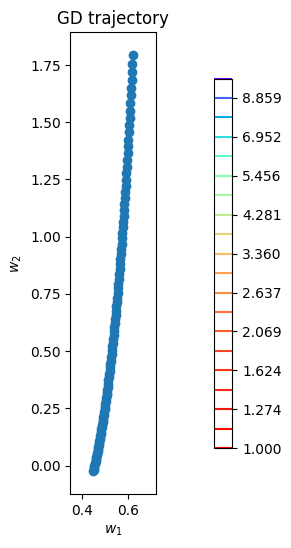

Learning Rate = 0.001


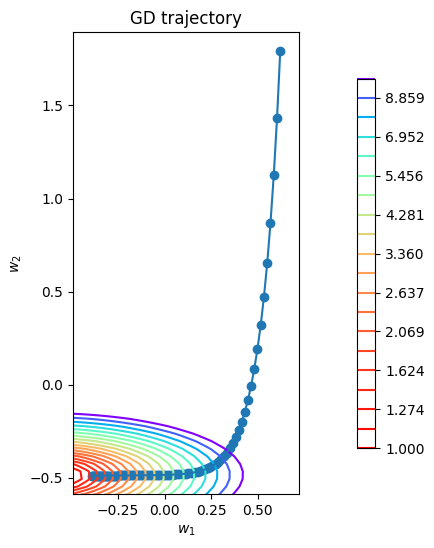

Learning Rate = 0.01


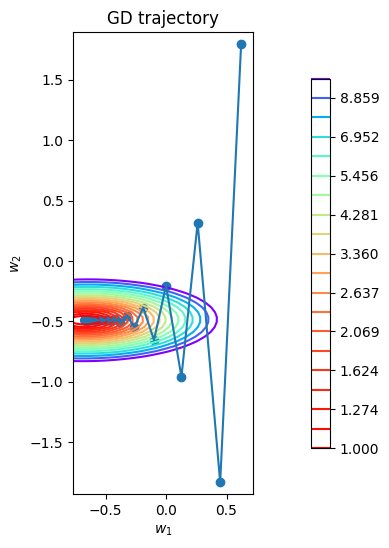

Learning Rate = 0.1


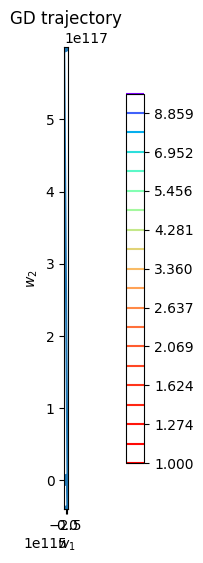

In [10]:
lr_list = np.logspace(-4, -1, 4)
for lr in lr_list:
    print(f"Learning Rate = {lr}")
    w_list = gradient_descent(w_init, X, y, loss, lr, 100)
    plot_gd(np.vstack((w_init, w_list)), X, y, loss)

При слишком маленьком lr градиентный спуск делает очень маленькие шаги, без резких скачков, ему может не хватить итераций, чтобы спуститься к локальному минимуму(сходится очень медленно).

Если lr будет слишком большом, веса будут меняться слишком сильно и он будет перепрыгивать минимум, то есть не будет сходимости.

Теперь реализуем стохастический градиентный спуск. Функция должна принимать все те же параметры, что и функция `gradient_descent`, но ещё параметр `batch_size`, отвечающий за размер батча.

Функция должна как и раньше реализовывать цикл, в котором происходит шаг градиентного спуска, но на каждом шаге считать градиент не по всей выборке `X`, а только по случайно выбранной части.

Подсказка: для выбора случайной части можно использовать [`np.random.choice`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html) с правильным параметром `size`, чтобы выбрать случайные индексы, а потом проиндексировать получившимся массивом массив `X`:
```
batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
batch = X[batch_indices]
```

In [11]:
def stochastic_gradient_descent(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    batch_size: int,
    n_iterations: int = 1000,
) -> np.ndarray:
    """Weights optimization with stochastic gradient descent

    Args:
        w_init: initial weights, (n_features,)
        X: array with dataset objects, (n_samples, n_features)
        y: array with ground truth values, (n_samples,)
        loss: BaseLoss instance to calculate loss and gradients
        lr: learning rate, float
        batch_size: number of samples in each batch, int
        n_iterations: number of iterations, int

    Returns:
        History of weights on each step, (n_iterations, n_features)
    """
    w_history = np.zeros((n_iterations, w_init.size))
    curr_w = w_init.copy()

    for i in range(n_iterations):
        batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
        grad = loss.calc_grad(X[batch_indices], y[batch_indices], curr_w)
        curr_w -= lr * grad
        w_history[i] = curr_w
    return w_history

При помощи функций `stochastic_gradient_descent` и `plot_gd` нарисуйте траекторию градиентного спуска для разных значений длины шага (параметра `lr`) и размера подвыборки (параметра `batch_size`). Используйте не менее четырёх разных значений для `lr` и `batch_size`.

Сделайте и опишите свои выводы о том, как параметры `lr` и `batch_size` влияют на поведение стохастического градиентного спуска. Как отличается поведение стохастического градиентного спуска от обычного?

Обратите внимание, что в нашем датасете всего 300 объектов, так что `batch_size` больше этого числа не будет иметь смысла.

Learning Rate = 0.0001
Batch size = 1


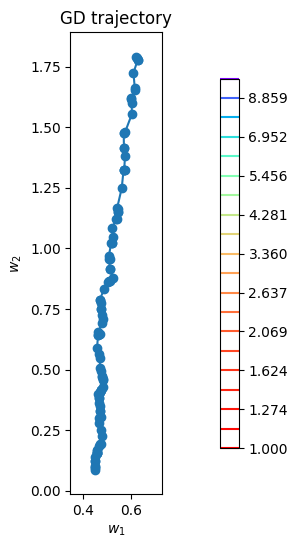

Learning Rate = 0.0001
Batch size = 10


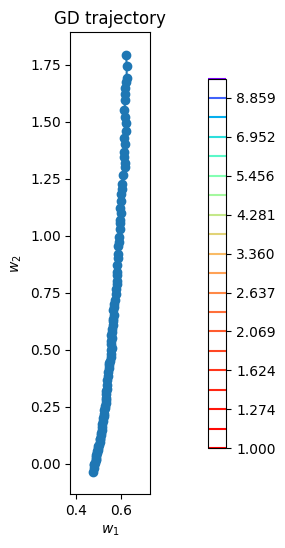

Learning Rate = 0.0001
Batch size = 50


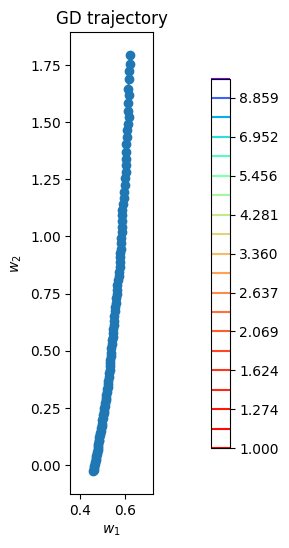

Learning Rate = 0.0001
Batch size = 100


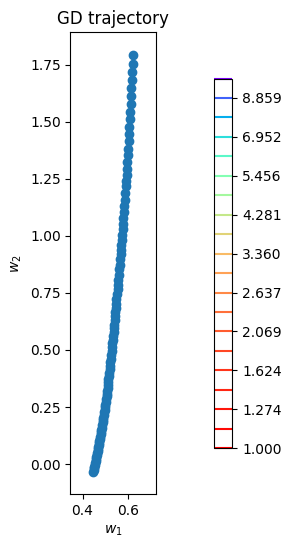

Learning Rate = 0.0001
Batch size = 200


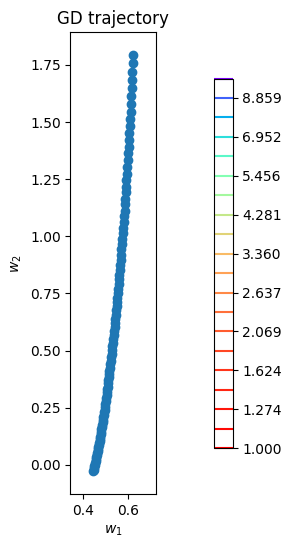

Learning Rate = 0.001
Batch size = 1


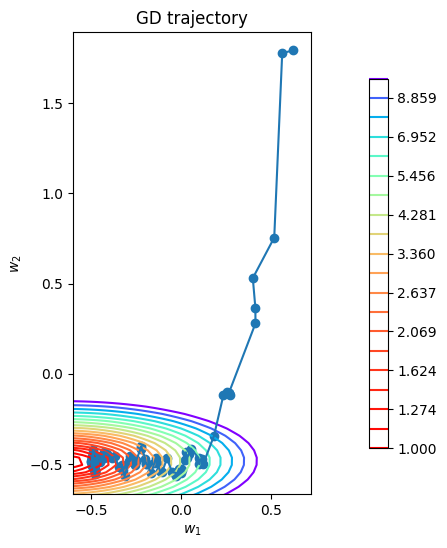

Learning Rate = 0.001
Batch size = 10


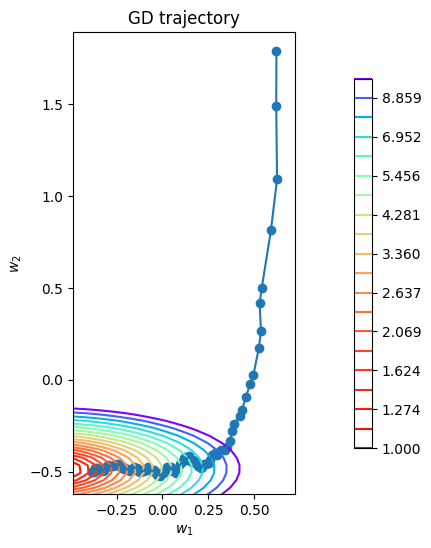

Learning Rate = 0.001
Batch size = 50


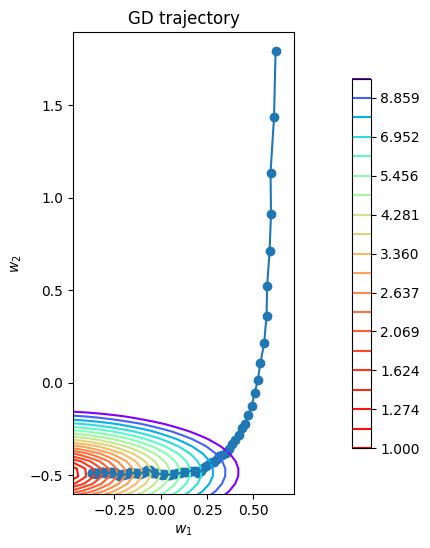

Learning Rate = 0.001
Batch size = 100


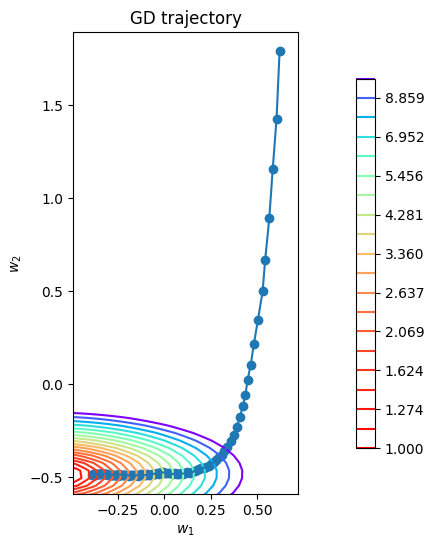

Learning Rate = 0.001
Batch size = 200


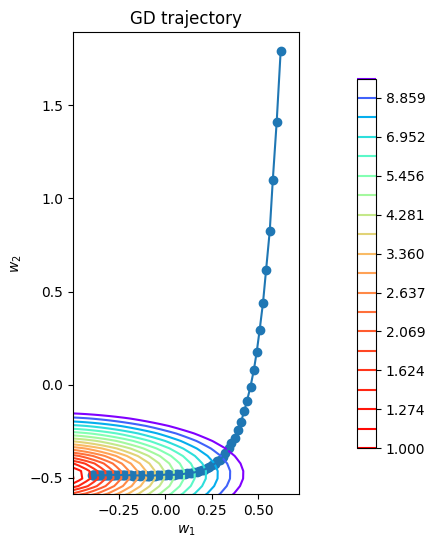

Learning Rate = 0.01
Batch size = 1


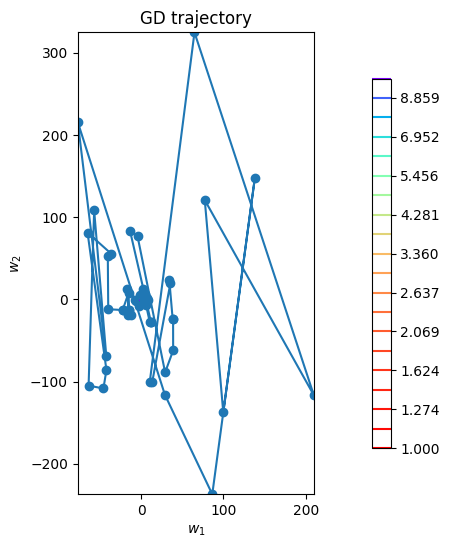

Learning Rate = 0.01
Batch size = 10


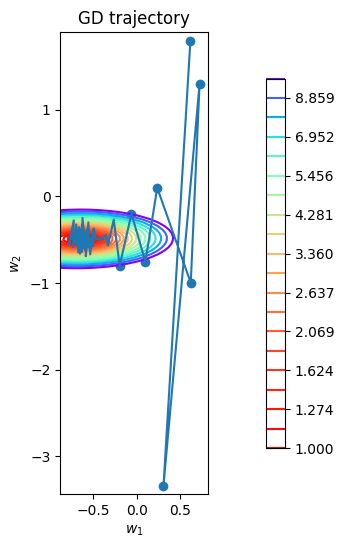

Learning Rate = 0.01
Batch size = 50


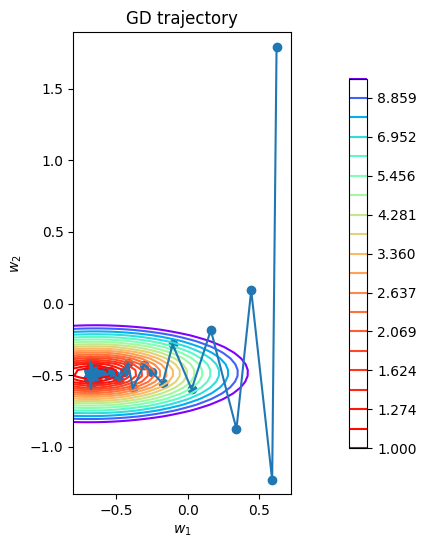

Learning Rate = 0.01
Batch size = 100


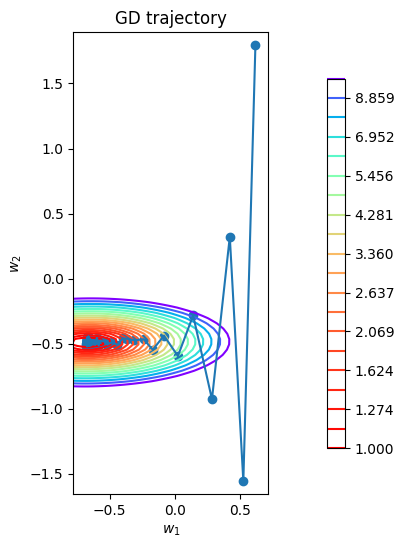

Learning Rate = 0.01
Batch size = 200


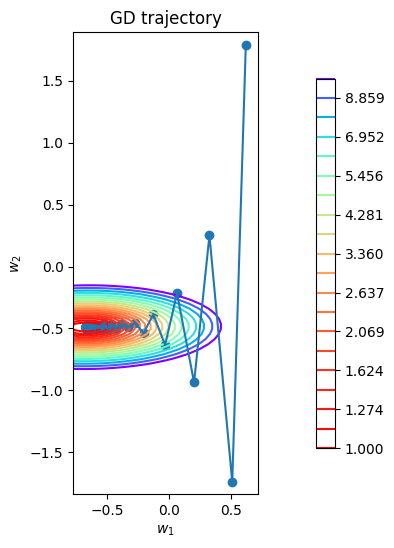

Learning Rate = 0.1
Batch size = 1


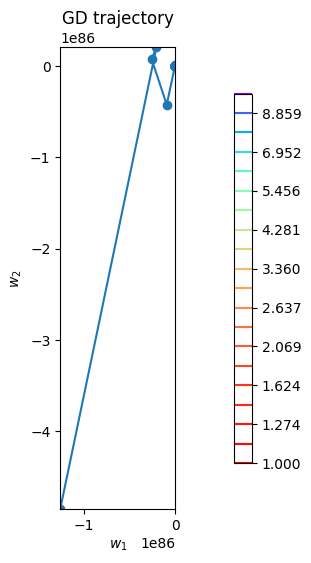

Learning Rate = 0.1
Batch size = 10


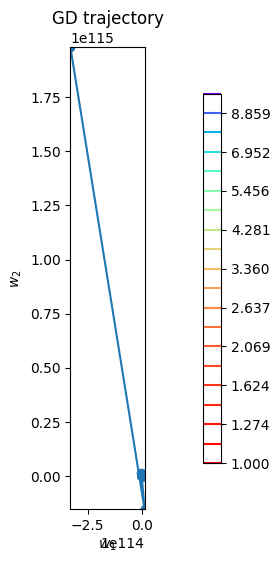

Learning Rate = 0.1
Batch size = 50


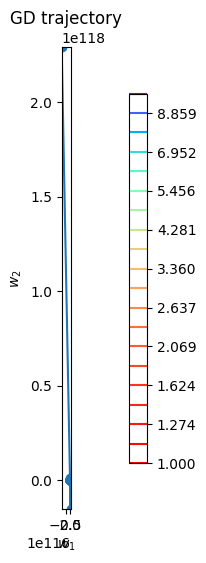

Learning Rate = 0.1
Batch size = 100


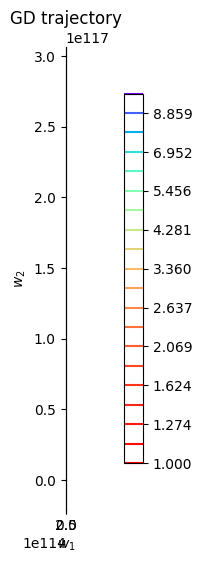

Learning Rate = 0.1
Batch size = 200


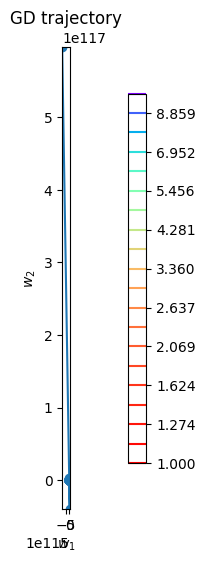

In [12]:
from itertools import product

batch_size_list = [1, 10, 50, 100, 200]
for lr, batch_size in product(lr_list, batch_size_list):
    print(f"Learning Rate = {lr}")
    print(f"Batch size = {batch_size}")
    w_list = stochastic_gradient_descent(w_init, X, y, loss, lr, batch_size, 100)
    plot_gd(np.vstack((w_init, w_list)), X, y, loss)

Чем меньше batch_size, тем менее точные будут шаги. в них будет больше шума. Это может помочь избегать локальные минимумы. При большом batch_size поведение будет близким к обычному GD, более плавная сходимость.

При маленьком lr мы будем точно также как при обычном градиентном спуске топтаться на месте либо перескакивать минимум при большом lr

В отличие от обычного градиентного спуска, стохастический градиентный спуск делает менее точные, зашумленные шаги, из-за того что, что мы считаем градиент не на всей выборке, а на какой-то части, но в среднем он все равно сходится при правильном lr и размере батча. Из графиков видно, что при стохастическом градиентном спуске нужно уменьшать lr, так как мы можем долго прыгать возле минимума, из-за меньшей точности

Вы могли заметить, что поведение градиентного спуска, особенно стохастической версии, очень сильно зависит от размера шага.

Как правило, в начале спуска мы хотим делать большие шаги, чтобы поскорее подойти поближе к минимуму, а позже мы уже хотим делать шаги маленькие, чтобы более точнее этого минимума достичь и не "перепрыгнуть" его.

Чтобы достичь такого поведения мы можем постепенно уменьшать длину шага с увеличением номера итерации. Сделать это можно, например, вычисляя на каждой итерации длину шага по следующей формуле:

$$
    \eta_t
    =
    \lambda
    \left(
        \frac{s_0}{s_0 + t}
    \right)^p
$$

где $\eta_t$ — длина шага на итерации $t$, $\lambda$ — начальная длина шага (параметр `lr` у нас), $s_0$ и $p$ — настраиваемые параметры.

Реализуйте SGD на этот раз с затухающим шагом по формуле выше. Параметр $s_0$ возьмите равным 1. Параметр $p$ возьмите из нового аргумента функции `p`.

In [13]:
def stochastic_gradient_descent_with_decay(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    batch_size: int,
    p: float,
    n_iterations: int = 1000,
) -> np.ndarray:
    """Weights optimization with SGD and learning rate decay

    Args:
        w_init: initial weights, (n_features,)
        X: array with dataset objects, (n_samples, n_features)
        y: array with ground truth values, (n_samples,)
        loss: BaseLoss instance to calculate loss and gradients
        lr: learning rate, float
        batch_size: number of samples in each batch, int
        p: learning rate decay factor, float
        n_iterations: number of iterations, int

    Returns:
        History of weights on each step, (n_iterations, n_features)
    """
    w_history = np.zeros((n_iterations, w_init.size))
    curr_w = w_init.copy()

    for i in range(n_iterations):
        batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
        grad = loss.calc_grad(X[batch_indices], y[batch_indices], curr_w)

        curr_w -= lr * (1 / (1 + i + 1)) ** p * grad
        w_history[i] = curr_w
    return w_history

При помощи новой функции `stochastic_gradient_descent_with_decay` и функции `plot_gd` нарисуйте траекторию градиентного спуска для разных значений параметра `p`. Используйте не менее четырёх разных значений для `p`. Хорошими могут быть значения, лежащие в промежутке от 0.1 до 1.
Параметр `lr` возьмите равным 0.01, а параметр `batch_size` равным 10.

Сделайте и опишите свои выводы о том, как параметр `p` влияет на поведение стохастического градиентного спуска

P = 0.1


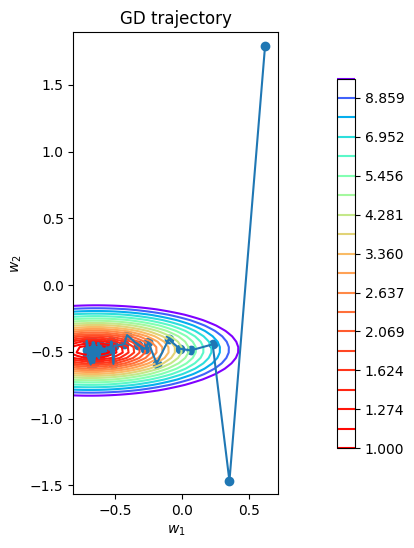

P = 0.21544346900318834


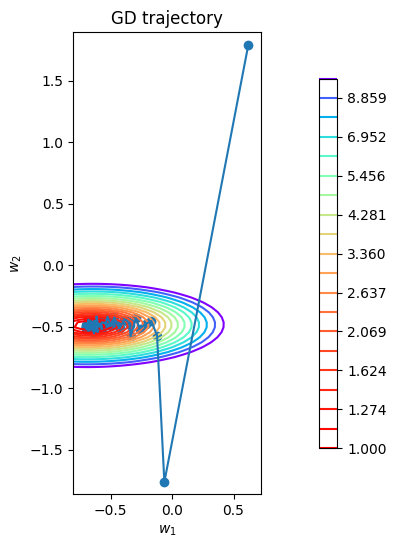

P = 0.46415888336127786


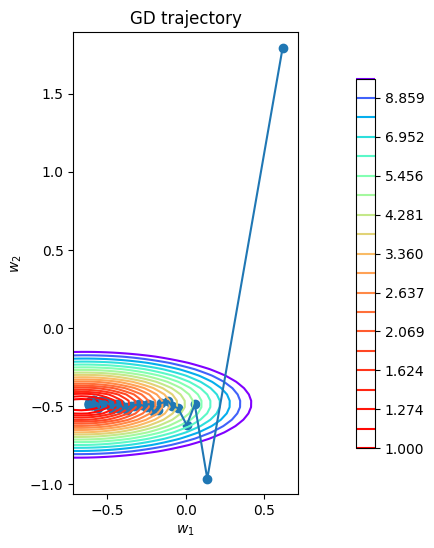

P = 1.0


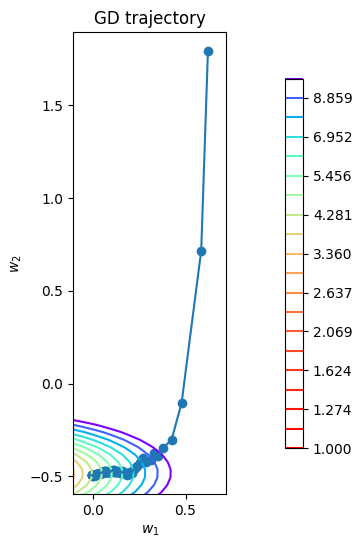

In [14]:
p_list = np.logspace(-1, 0, 4)
for p in p_list:
    print(f"P = {p}")
    w_list = stochastic_gradient_descent_with_decay(w_init, X, y, loss, 0.01, 10, p, 100)
    plot_gd(np.vstack((w_init, w_list)), X, y, loss)

При увеличении p  шаг все более резко уменьшается с каждой итерацией, следовательно чем ближе мы к минимумы тем более аккуратные шаги мы будем делать. При слишком больших p шаги будут слишком маленькими и будет очень медленная сходимость.
При маленьих значениях p шаг будет уменьшаться более плавно, возле минимума будут большие шаги, большая вероятность перескачить минимум. Неустойчивая сходимость, потребуется больше итераций

Сравните сходимость обычного градиентного спуска и стохастичекой версии:
Нарисуйте график зависимости значения лосса (его можно посчитать при помощи метода `calc_loss`, используя $x$ и $y$ из датасета и $w$ с соответствующей итерации) от номера итерации для траекторий, полученных при помощи обычного и стохастического градиентного спуска с одинаковыми параметрами. Параметр `batch_size` возьмите равным 10.

Видно ли на данном графике преимущество SGD? Почему?

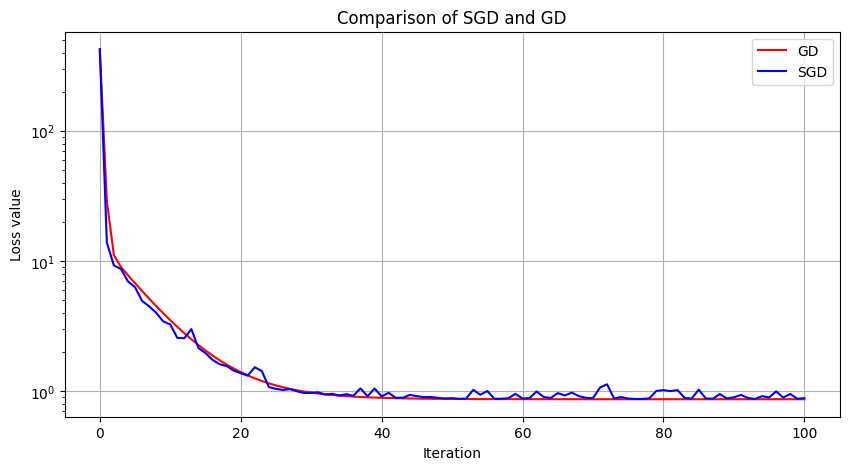

In [16]:
n_iters = 100
batch_size = 10
lr = 0.005
p = 0.01

loss = MSELoss()
w_gd_list = np.vstack((w_init, gradient_descent(w_init, X, y, loss, lr, n_iters)))
w_sgd_list = np.vstack((w_init, stochastic_gradient_descent_with_decay(w_init, X, y, loss, lr, batch_size, p, n_iters)))

gd_loss = [loss.calc_loss(X, y, w_gd_list[i]) for i in range(n_iters + 1)]
sgd_loss = [loss.calc_loss(X, y, w_sgd_list[i]) for i in range(n_iters + 1)]


iterations = np.arange(n_iters + 1)

plt.figure(figsize=(10, 5))

plt.plot(iterations, gd_loss, color="red", label="GD")
plt.plot(iterations, sgd_loss, color="blue", label="SGD")
plt.yscale("log")

plt.title("Comparison of SGD and GD")
plt.xlabel("Iteration")
plt.ylabel("Loss value")

plt.grid(True)
plt.legend()
plt.show()

Да, видно преимущество SGD, так как за одинаковое количество итераций GD и SGD почти одинаково сходятся, но при вычисление SGD гораздо бычтрее, так как мы считаем градиент не на всей выборке

## Часть 2. Линейная регрессия (5 баллов)

Напишем наш класс для линейной регрессии. Он будет использовать интерфейс, знакомый нам из библиотеки `sklearn`.

В методе `fit` мы будем подбирать веса `w` при помощи градиентного спуска нашим методом `gradient_descent`. Не забывайте про единичный признак!

В методе `predict` мы будем применять нашу регрессию к датасету,

In [17]:
class LinearRegression:
    def __init__(self, loss: BaseLoss, lr: float = 0.1) -> None:
        self.loss = loss
        self.lr = lr

    def fit(self, X: np.ndarray, y: np.ndarray) -> "LinearRegression":
        X = np.asarray(X)
        y = np.asarray(y)
        X = np.c_[X, np.ones(X.shape[0])]
        w_init = np.random.randn(X.shape[1])
        self.w = gradient_descent(w_init, X, y, self.loss, self.lr)[-1]

        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        # Проверяем, что регрессия обучена, то есть, что был вызван fit и в нём был установлен атрибут self.w
        assert hasattr(self, "w"), "Linear regression must be fitted first"
        X = X = np.c_[X, np.ones(X.shape[0])]
        return X @ self.w

Теперь у нас есть наш класс линейной регрессии. Более того, мы можем управлять тем, какую функцию потерь мы оптимизируем, просто передавая разные классы в параметр `loss` при инициализации.

Пока у нас нет никаких классов кроме `MSELoss`, но скоро они появятся.

Для `MSELoss` мы бы создавали наш объект линейной регрессии, например, так:

In [18]:
linear_regression = LinearRegression(MSELoss())

Применим нашу регрессию на реальном датасете. Загрузим датасет с машинами, который был у вас на семинарах:

In [19]:
import pandas as pd

X_raw = pd.read_csv(
    "http://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data",
    header=None,
    na_values=["?"],
)
X_raw = X_raw[~X_raw[25].isna()].reset_index()
X_raw.head()

,index,0,1,2,3,4,5,6,7,8,...,16,17,18,19,20,21,22,23,24,25
0,0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,...,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,3,2,164.0,audi,gas,std,four,sedan,fwd,front,...,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,4,2,164.0,audi,gas,std,four,sedan,4wd,front,...,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0


In [20]:
y = X_raw[25]
X_raw = X_raw.drop(25, axis=1)

Как обычно обработайте датасет всеми нужными методами, чтобы на нём можно было обучать линейную регрессию:

* Разделите датасет на обучающую и тестовую выборку
* Заполните пропуски
* Нормализуйте числовые признаки
* Закодируйте категориальные переменные

In [21]:
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [22]:
X_raw.isna().sum()[X_raw.isna().sum() > 0]

,0
1,37
5,2
18,4
19,4
21,2
22,2


In [23]:
X_raw = X_raw.drop(columns=["index"])

X_train, X_test, y_train, y_test = train_test_split(X_raw, y, test_size=0.2, random_state=42)

In [24]:
numeric_features = X_train.select_dtypes([np.number]).columns
categorical = list(X_train.dtypes[X_train.dtypes == "object"].index)

train_means = X_train[numeric_features].mean()
X_train = X_train.fillna(train_means)
X_test = X_test.fillna(train_means)

X_train = X_train.fillna("NotGiven")
X_test = X_test.fillna("NotGiven")

In [43]:
column_transformer = ColumnTransformer(
    transformers=[
        ("ohe", OneHotEncoder(handle_unknown="ignore"), categorical),
        ("scaling", StandardScaler(), numeric_features),
    ]
)

pipeline = Pipeline(steps=[("ohe_and_scaling", column_transformer), ("regression", linear_regression)])

Обучите линейную регрессию на обучающей выборке

In [44]:
model = pipeline.fit(X_train, y_train)

Для оценки качества реализуем `r2_score`, который является нормализацией `mean_square_error`.

In [33]:
def r2(y_true: np.ndarray, y_predicted: np.ndarray) -> float:
    return 1 - np.sum((y_true - y_predicted) ** 2) / np.sum((y_true - y_true.mean()) ** 2)

Посчитайте ошибку обученной регрессии на обучающей и тестовой выборке.

In [45]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print(f"Train r2_score: {r2(y_train, y_train_pred)}")
print(f"Test r2_score: {r2(y_test, y_test_pred)}")

Train r2_score: 0.9700501294634517
Test r2_score: 0.9089866747501262


Наша модель переобучилась. Давайте как обычно в такой ситуации добавим к ней L2 регуляризацию. Для этого нам нужно написать новый класс лосса.

Формула функции потерь для MSE с L2 регуляризацией выглядит так:
$$
Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell (\langle x_i, w \rangle - y_i)^2 + \lambda ||w||^2
$$

Или в матричном виде:

$$
Q(w, X, y) = \frac{1}{\ell} || Xw - y ||^2 + \lambda ||w||^2
$$

Где $\lambda$ — коэффициент регуляризации

Градиент выглядит так:

$$
\nabla_w Q(w, X, y) = \frac{2}{\ell} X^T(Xw-y) + 2 \lambda w
$$

Обратите внимание, что последний элемент вектора `w` — это bias (в классе `LinearRegression` к матрице `X` добавляется колонка из единиц — константный признак).

**Вопрос**: надо ли регуляризовывать bias?

**Ответ**: не надо, потому что тогда модель будет пытаться построить смещенную гиперплоскость. Мы хотим упростить нашу модель, но bias никак не зависит от признаков

Не забудьте убрать последний элемент из `w` при подсчёте слагаемого $\lambda||w||^2$ в `calc_loss` и занулить его при подсчёте слагаемого $2 \lambda w$ в `calc_grad`

In [46]:
class MSEL2Loss(BaseLoss):
    def __init__(self, coef: float = 1.0):
        self.coef = coef

    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        return np.mean(X @ w - y) ** 2 + self.coef * np.sum(w[:-1] ** 2)

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        w[-1] = 0
        return 2 / y.size * X.T @ (X @ w - y) + 2 * self.coef * w

Теперь мы можем использовать лосс с l2 регуляризацией в нашей регрессии, например, так:

In [47]:
linear_regression = LinearRegression(MSEL2Loss(0.1))

Обучите регрессию с лоссом `MSEL2Loss`. Подберите хороший коэффициент регуляризации и добейтесь улучшения результата на тестовой выборке. Сравните результат на обучающей и тестовой выборке с регрессией без регуляризации.

In [52]:
loss_functions = {"msel2": MSEL2Loss, "mse": MSELoss}

In [53]:
from sklearn.model_selection import KFold


def grid_search_cv(lr_list=[0.1], loss_params=[1.0], loss_name="msel2", cv=5):
    best_params = {"lr": None, "loss_param": None}
    best_score = float("-inf")

    for lr, loss_param in product(lr_list, loss_params):
        loss_cls = loss_functions[loss_name]
        loss = loss_cls() if loss_name == "mse" else loss_cls(loss_param)
        pipeline = Pipeline(steps=[("ohe_and_scaling", column_transformer), ("regression", LinearRegression(loss, lr))])
        scores = []
        kf = KFold(n_splits=cv, shuffle=True, random_state=42)
        for train_idx, val_idx in kf.split(X_train):
            model = pipeline.fit(X_train.iloc[train_idx], y_train.iloc[train_idx])
            y_pred = model.predict(X_train.iloc[val_idx])
            scores.append(r2(y_train.iloc[val_idx], y_pred))
        mean_score = np.mean(scores)
        if mean_score > best_score:
            best_score = mean_score
            best_params["lr"] = lr
            best_params["loss_param"] = loss_param
    return best_params, best_score

In [50]:
lambdas = np.logspace(-4, 0, 8)
lr_list = np.logspace(-4, -1, 8)
best_params, best_score = grid_search_cv(lr_list, lambdas, cv=5)

best_lr = best_params["lr"]
best_reg_coef = best_params["loss_param"]

print("Linear Regression with MSEL2Loss")
print(f"Best score: {best_score}")
print(f"With learning_rate: {best_lr}, loss_param: {best_reg_coef}")

Best score: 0.8356786357784278
With learning_rate: 0.1, loss_param: 0.0003727593720314938


In [51]:
pipeline = Pipeline(
    steps=[("ohe_and_scaling", column_transformer), ("regression", LinearRegression(MSEL2Loss(best_reg_coef), best_lr))]
)

model = pipeline.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print("Linear Regression with MSEL2Loss")
print(f"Train r2_score: {r2(y_train, y_train_pred)}")
print(f"Test r2_score: {r2(y_test, y_test_pred)}")

Train r2_score: 0.9694329564906824
Test r2_score: 0.919649621582463


In [55]:
best_params, best_score = grid_search_cv(lr_list, loss_name="mse", cv=5)

best_lr = best_params["lr"]

print("Linear Regression with MSELoss")
print(f"Best score: {best_score}")
print(f"With learning_rate: {best_lr}")

Best score: 0.8361560646683598
With learning_rate: 0.013894954943731374


In [56]:
pipeline = Pipeline(
    steps=[("ohe_and_scaling", column_transformer), ("regression", LinearRegression(MSELoss(), best_lr))]
)

model = pipeline.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print("Linear Regression with MSELoss")
print(f"Train r2_score: {r2(y_train, y_train_pred)}")
print(f"Test r2_score: {r2(y_test, y_test_pred)}")

Linear Regression with MSELoss
Train r2_score: 0.9699291294185123
Test r2_score: 0.9121837525906407


По сравнению с линейной регрессией без регулиразации, видно, что скор на тренировочной выборке почти не изменился, но зато на тестовой вырос. Переобучение уменьшилось

В нашем датасете могут быть выбросы, с ними хорошо помогает бороться Huber Loss. Вдали от нуля он работает как Mean Absolute Error и не реагирует на выбросы так сильно, как MSE. Давайте его реализуем и применим в нашей регрессии.

Напомним, что функция потерь Huber Loss'а выглядит так:


$$
    Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell \phi_\varepsilon (\langle x_i, w \rangle - y_i)
$$
$$
    \phi_\varepsilon(z) = \begin{cases} \frac 1 2 z^2, - \varepsilon < z < \varepsilon, \\\varepsilon (|z| - \frac 1 2 \varepsilon), иначе \\ \end{cases}
$$


А градиент так:
$$
    \nabla_w Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell x_i \nabla_z \phi_\varepsilon (\langle x_i, w \rangle - y_i)
$$
$$
    \nabla_z \phi_\varepsilon(z) = \begin{cases} z, - \varepsilon < z < \varepsilon, \\\varepsilon \text{ sign}(z), иначе \\ \end{cases}
$$

In [57]:
class HuberLoss(BaseLoss):
    def __init__(self, eps: float) -> None:
        self.eps = eps

    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        diff = X @ w - y
        mask = (diff > -self.eps) & (diff < self.eps)
        first_sum = np.sum(0.5 * diff[mask] ** 2)
        second_sum = np.sum(self.eps * (np.abs(diff[~mask]) - 0.5 * self.eps))
        return 1 / y.size * (first_sum + second_sum)

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        diff = X @ w - y
        mask = (diff > -self.eps) & (diff < self.eps)

        first_grad = X[mask].T @ (diff[mask])
        second_grad = X[~mask].T @ (np.sign(diff[~mask]) * self.eps)

        return 1 / y.size * (first_grad + second_grad)

In [58]:
loss_functions["huber"] = HuberLoss

Обучите регрессию с лоссом `HuberLoss`. Сравните результат на обучающей и тестовой выборке с регрессией, обученной c `MSELoss`.

In [59]:
eps_list = np.linspace(1, 100, 5)
best_params, best_score = grid_search_cv(lr_list, eps_list, loss_name="huber", cv=8)

best_lr = best_params["lr"]
best_eps = best_params["loss_param"]

print("Linear Regression with HuberLoss")
print(f"Best score: {best_score}")
print(f"With learning_rate: {best_lr}, loss_param: {best_eps}")

Best score: 0.8329929841484511
With learning_rate: 0.03727593720314938, loss_param: 29.285714285714285


In [64]:
pipeline = Pipeline(
    steps=[("ohe_and_scaling", column_transformer), ("regression", LinearRegression(HuberLoss(best_eps), best_lr))]
)

model = pipeline.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print("Linear Regression with HuberLoss")
print(f"Train r2_score: {r2(y_train, y_train_pred)}")
print(f"Test r2_score: {r2(y_test, y_test_pred)}")

Linear Regression with HuberLoss
Train r2_score: 0.9006978179041064
Test r2_score: 0.8069646375306496


Huber Loss показал плохие результаты, это может быть из-за неудачного подбора гиперпараметров, либо в выбросах есть какая-то закономерность, но из-за того что мы считаем ошибку на них как MAE, эта закономерность теряется

In [66]:
pipeline = Pipeline(
    steps=[("ohe_and_scaling", column_transformer), ("regression", LinearRegression(HuberLoss(70), 0.1))]
)

model = pipeline.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print("Linear Regression with HuberLoss")
print(f"Train r2_score: {r2(y_train, y_train_pred)}")
print(f"Test r2_score: {r2(y_test, y_test_pred)}")

Linear Regression with HuberLoss
Train r2_score: 0.9559913221653775
Test r2_score: 0.9260424454523768


Вставьте ваш любимый мем 2025 в ячейку ниже:

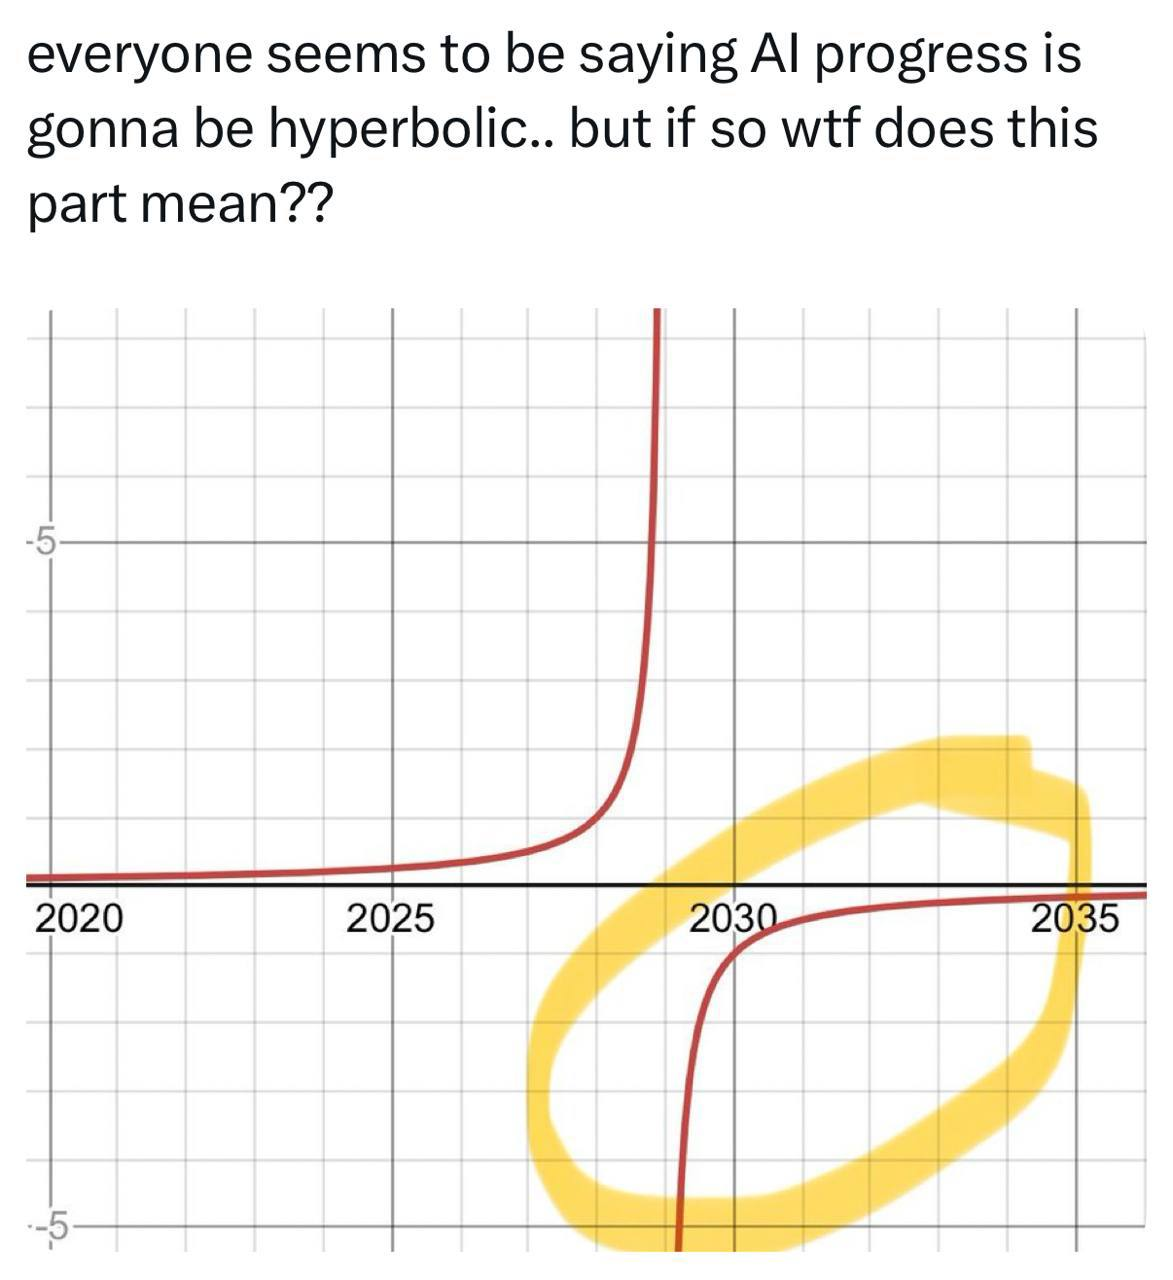